In [15]:
# 1) Importar librerías básicas
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [33]:
# # 2) Descargar el ZIP y extraerlo
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_path = tf.keras.utils.get_file(
    fname='cats_and_dogs_filtered.zip',
    origin=_URL,
    extract=True
)

# Verifica qué carpetas creó
cache_dir = os.path.dirname(zip_path)
print("Carpetas en cache_dir:", os.listdir(cache_dir))

# Define la carpeta base (debería llamarse 'cats_and_dogs_filtered')
base_dir = os.path.join(cache_dir, 'cats_and_dogs_filtered_extracted', 'cats_and_dogs_filtered') # Corrected directory name
print("Dentro de cats_and_dogs_filtered:", os.listdir(base_dir))

# Rutas finales
train_dir      = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir       = os.path.join(base_dir, 'test') # si NO existe, COMENTA esta línea
IMG_HEIGHT = 150
IMG_WIDTH  = 150
BATCH_SIZE = 32

Carpetas en cache_dir: ['cats_and_dogs_extracted', 'cats_and_dogs_filtered_extracted', 'cats_and_dogs.zip', 'cats_and_dogs_filtered.zip']
Dentro de cats_and_dogs_filtered: ['vectorize.py', 'train', 'validation']


In [55]:
# 3) Crear generadores (solo reescalar de 0–255 a 0–1)
train_data_gen = ImageDataGenerator(rescale=1./255)
train_data = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_data_gen = ImageDataGenerator(rescale=1./255)
val_data = validation_data_gen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Si test_dir EXISTE, descomenta estas dos líneas:
test_data_gen = ImageDataGenerator(rescale=1./255)
test_data = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
 )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


FileNotFoundError: [Errno 2] No such file or directory: '/root/.keras/datasets/cats_and_dogs_filtered_extracted/cats_and_dogs_filtered/test'

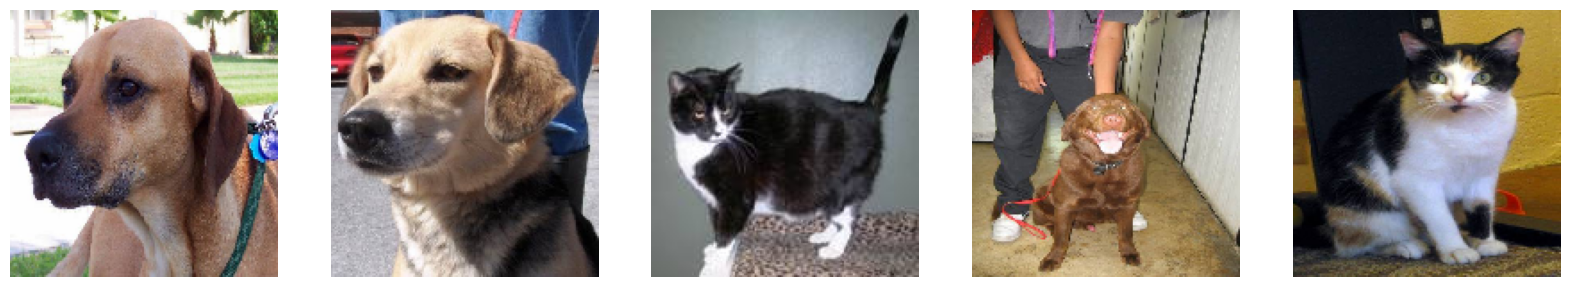

In [35]:
# 4) Función para dibujar imágenes
def plotImages(images_arr, probabilities=None):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    for i, img in enumerate(images_arr):
        axes[i].imshow(img)
        axes[i].axis('off')
        if probabilities is not None:
            p = probabilities[i] * 100
            axes[i].set_title(f"{p:.1f}% perro")
    plt.show()

# Toma un lote de entrenamiento y dibuja 5
sample_training_images, _ = next(train_data)
plotImages(sample_training_images[:5])



In [37]:
# 5) Data augmentation (aumentos) para entrenamiento
augmented_train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



Found 2000 images belonging to 2 classes.


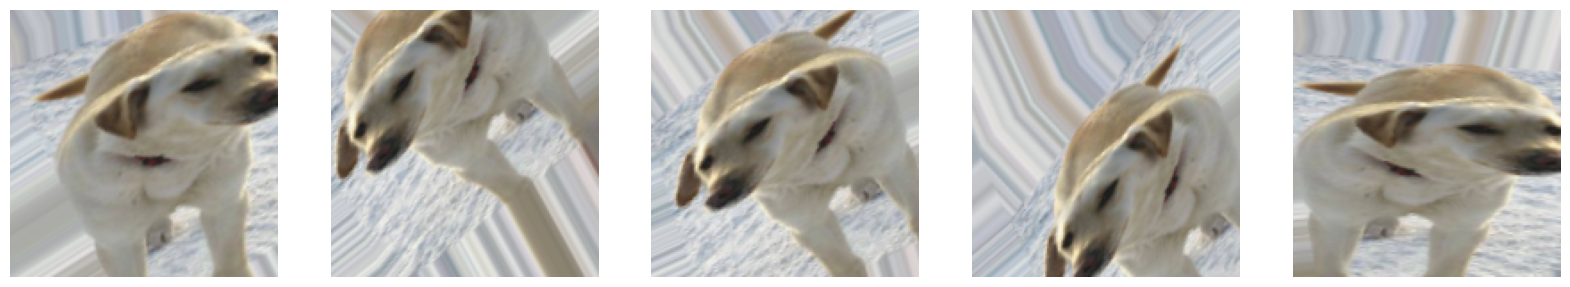

In [38]:
# 6) Mostrar 5 variaciones de la misma imagen
augmented_data = augmented_train_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='binary'
)
orig, _ = next(augmented_data)
variaciones = [augmented_train_gen.random_transform(orig[0]) for _ in range(5)]
plotImages(variaciones)

In [39]:
# # 7) Definir y compilar la red neuronal (CNN)
model = Sequential([
    Conv2D(32, (3,3), activation='relu',
           input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,636,481 (40.57 MB)

 Trainable params: 10,636,481 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
## 8) Entrenar el modelo
EPOCHS = 10
steps_per_epoch  = train_data.samples // BATCH_SIZE
validation_steps = val_data.samples // BATCH_SIZE

history = model.fit(
    augmented_train_gen.flow_from_directory(
        train_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    ),
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_data,
    validation_steps=validation_steps
)

model.summary()



Found 2000 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.4917 - loss: 1.6772 - val_accuracy: 0.5968 - val_loss: 0.6908
Epoch 2/10
 1/62 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - accuracy: 0.5312 - loss: 0.6908

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 323ms/step - accuracy: 0.5312 - loss: 0.6908 - val_accuracy: 0.6008 - val_loss: 0.6908
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5639 - loss: 0.6833 - val_accuracy: 0.5938 - val_loss: 0.6577
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 307ms/step - accuracy: 0.5625 - loss: 0.6725 - val_accuracy: 0.5887 - val_loss: 0.6550
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6086 - loss: 0.6658 - val_accuracy: 0.6179 - val_loss: 0.6620
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 298ms/step - accuracy: 0.5625 - loss: 0.7396 - val_accuracy: 0.6169 - val_loss: 0.6657
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6077 - loss: 0.6624 - val_accuracy: 0.6270 - val_loss: 0.6585
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.7188 - loss: 0.6386 - val_accuracy: 0.6250 - val_loss: 0.6586
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.6257 - loss: 0.6495 - val_accuracy: 0.6401 - val_

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,909,445 (121.72 MB)

 Trainable params: 10,636,481 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,272,964 (81.15 MB)

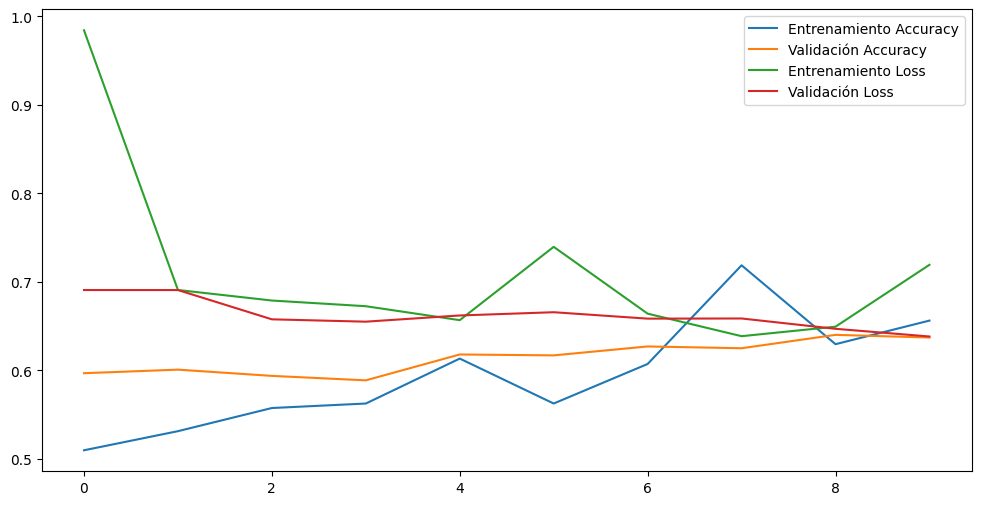

In [41]:
# 9) Graficar precisión y pérdida
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, acc,     label='Entrenamiento Accuracy')
plt.plot(epochs_range, val_acc, label='Validación Accuracy')
plt.plot(epochs_range, loss,    label='Entrenamiento Loss')
plt.plot(epochs_range, val_loss,label='Validación Loss')
plt.legend(loc='upper right')
plt.show()


In [62]:
probabilities = model.predict(
    val_data,
    steps=val_data.samples // BATCH_SIZE + 1
).flatten()
answers = val_data.classes

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 364ms/step


In [64]:
probabilities = model.predict(
    test_data,
    steps=test_data.samples // BATCH_SIZE + 1
).flatten()
plotImages(next(test_data)[0], probabilities[:BATCH_SIZE])

NameError: name 'test_data' is not defined

In [63]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 52.0% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!
